In [8]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.optim import lr_scheduler
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
from torch.utils.data import Dataset, DataLoader
import os
import time
import copy
from torchvision import models

In [2]:
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [3]:
BATCH_SIZE = 64
epochs = 30
TEST = "C:\\Users\\sanzh/Desktop/CHOC Data/test"
VAL = "C:\\Users\\sanzh/Desktop/CHOC Data/Val"
TRAIN_filter = "C:\\Users\\sanzh/Desktop/CHOC Data/train_pda_filtered"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
transform_normalize = transforms.Compose([transforms.Resize((224, 224)),
                                   transforms.ToTensor(),
                                   transforms.Normalize(mean = [0.1295, 0.1322, 0.1428],
                                                        std = [0.1695, 0.1727, 0.1858])]) 

In [5]:
# Split train_filter data into training and validation set using 80-20 split

filtered = torchvision.datasets.ImageFolder(TRAIN_filter, transform = transform_normalize)
train_length = round(0.8*len(filtered))
val_length = len(filtered) - train_length
class_names = filtered.classes
train, val = torch.utils.data.random_split(filtered, [train_length, val_length])

In [6]:
# Initialize train and validation dataset and dataloaders

train_loader = DataLoader(
    train,
    batch_size = BATCH_SIZE,
    shuffle = True,
    num_workers = 2
)
val_loader = DataLoader(
    val,
    batch_size = BATCH_SIZE,
    shuffle = True,
    num_workers = 2
)

In [7]:
def train(model, trainloader, valloader, optimizer, criterion, scheduler, num_epochs = epochs):
    train_loss = []
    train_acc = []
    val_loss = []
    val_acc = []
    startTime = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0  
    for epoch in range(epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        for phase in ['train', 'val']:
            totalLoss = 0.0
            totalCorrect = 0
            if phase == 'train':
                model.train()
                for inputs, labels in trainloader:
                    inputs = inputs.to(device)
                    labels = labels.to(device)
                    optimizer.zero_grad()
                    with torch.set_grad_enabled(True) :
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)
                        loss.backward()
                        optimizer.step()
                    totalLoss += loss.item() * inputs.size(0)
                    totalCorrect += torch.sum(preds == labels.data)
                scheduler.step()
                epoch_loss = totalLoss/ len(trainloader.dataset)
                epoch_acc = totalCorrect.double()/len(trainloader.dataset)
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc)
            if phase == 'val':
                model.eval()
                for inputs, labels in valloader:
                    inputs = inputs.to(device)
                    labels = labels.to(device)
                    optimizer.zero_grad()
                    with torch.set_grad_enabled(False):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)
                    totalLoss += loss.item() * inputs.size(0)
                    totalCorrect += torch.sum(preds == labels.data)
                epoch_loss = totalLoss/ len(valloader.dataset)
                epoch_acc = totalCorrect.double()/len(valloader.dataset)
                val_loss.append(epoch_loss)
                val_acc.append(epoch_acc)
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
        print()
    time_elapsed = time.time() - startTime
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')
    model.load_state_dict(best_model_wts)
    return [train_loss, train_acc, val_loss, val_acc] 

In [14]:
# Loading model and setting parameters

model = models.mnasnet1_0(pretrained = True)
model.classifier[-1].out_features = 2
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.001, momentum = 0.9)
scheduler = lr_scheduler.StepLR(optimizer, step_size = 7, gamma = 0.1)

In [16]:
metrics = train(model,  train_loader, val_loader, optimizer, criterion, scheduler, 30)

Epoch 0/29
----------
train Loss: 1.1571 Acc: 0.8153
val Loss: 3.2828 Acc: 0.3640

Epoch 1/29
----------
train Loss: 0.0772 Acc: 0.9745
val Loss: 3.0610 Acc: 0.4013

Epoch 2/29
----------
train Loss: 0.0459 Acc: 0.9868
val Loss: 3.0075 Acc: 0.4167

Epoch 3/29
----------
train Loss: 0.0333 Acc: 0.9912
val Loss: 2.8637 Acc: 0.4346

Epoch 4/29
----------
train Loss: 0.0276 Acc: 0.9924
val Loss: 2.8304 Acc: 0.4403

Epoch 5/29
----------
train Loss: 0.0194 Acc: 0.9954
val Loss: 2.7425 Acc: 0.4519

Epoch 6/29
----------
train Loss: 0.0164 Acc: 0.9967
val Loss: 2.6143 Acc: 0.4638

Epoch 7/29
----------
train Loss: 0.0135 Acc: 0.9975
val Loss: 2.4313 Acc: 0.4845

Epoch 8/29
----------
train Loss: 0.0121 Acc: 0.9978
val Loss: 2.2532 Acc: 0.5014

Epoch 9/29
----------
train Loss: 0.0127 Acc: 0.9977
val Loss: 2.0704 Acc: 0.5211

Epoch 10/29
----------
train Loss: 0.0133 Acc: 0.9977
val Loss: 1.8791 Acc: 0.5471

Epoch 11/29
----------
train Loss: 0.0121 Acc: 0.9976
val Loss: 1.7229 Acc: 0.5675

Ep

In [17]:
path = "C:\\Users\\sanzh/Desktop/MNASNet.pt"
torch.save(model.state_dict(), path)

In [18]:
epochs_range = list(range(30))
train_acc = metrics[1]
train_acc = [i.item() for i in train_acc]
val_acc = metrics[3]
val_acc = [i.item() for i in val_acc]
train_loss = metrics[0]
val_loss = metrics[2]

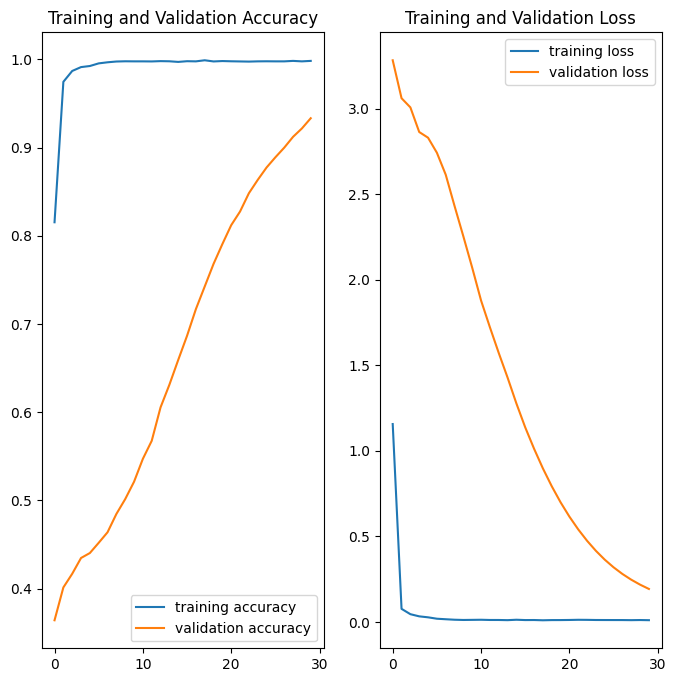

In [19]:
plt.figure(figsize = (8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_acc, label = "training accuracy")
plt.plot(epochs_range, val_acc, label = "validation accuracy")
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_loss, label='training loss')
plt.plot(epochs_range, val_loss, label='validation loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# Loading model

model = models.mnasnet1_0(pretrained = True)
model.classifier[-1].out_features = 2
model.to(device)
path = "C:\\Users\\sanzh/Desktop/MNASNet.pt"
model.load_state_dict(torch.load(path))